# MNIST
Try the same tests using 2d MNIST

In [ ]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# plt.style.use("seaborn-paper")
plt.style.use('seaborn-colorblind')
from matplotlib.pyplot import imshow
from IPython.display import display, HTML

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR
from ipywidgets import FloatProgress

from models.avae2d import AVAE2d, VAE2d
from utils_2d import make_affine2d, TransformedMNIST

%reload_ext autoreload
%autoreload 2
%matplotlib inline
device = "cuda:0"

## Check dataloaders

In [ ]:
mnist_path = "./data/"
trainset = TransformedMNIST(mnist_path, transform_type="none", train=True)
valset = TransformedMNIST(mnist_path, transform_type="none", train=False)

train_loader = DataLoader(trainset, batch_size=1)
val_loader = DataLoader(valset, batch_size=1)

stuff = next(iter(train_loader))
stuff.keys()
plt.imshow(stuff["data"][0, :, :].squeeze().numpy())

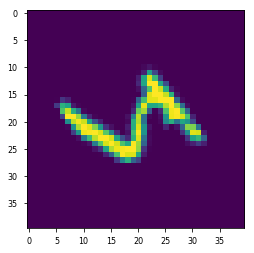

In [3]:
trainset = TransformedMNIST(mnist_path, transform_type="rand_rot", train=True)
train_loader = DataLoader(trainset, batch_size=1)
stuff = next(iter(train_loader))
plt.imshow(stuff["data"][0, :, :].squeeze().numpy())

In [6]:
stuff["data"][0, :, :].squeeze().numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

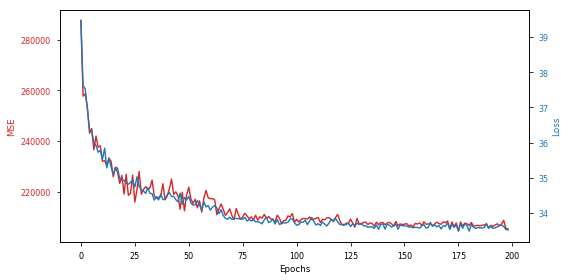

In [7]:
# save_path_aug = "./results/mnist/test1/avae_aug_noopt_l32"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l32"

# checkpoint_aug = torch.load(save_path_aug + "/best_ckpt.pth")
checkpoint_noaug = torch.load(save_path_noaug + "/best_ckpt.pth")

# fig = plt.figure(figsize=(8, 4))
# plt.plot(range(len(checkpoint_noaug['results']['val_mse'])), checkpoint_noaug['results']['val_mse'], label='mse')
# plt.plot(range(len(checkpoint_noaug['results']['val_mse'])), checkpoint_noaug['results']['val_loss'], label='loss')
# plt.title("Validation No aug over training")
# plt.xlabel("Epochs")
# plt.ylabel("Validation MSE / loss")
# plt.legend()
# plt.show()


fig, ax1 = plt.subplots(figsize=(8, 4))
color = "tab:red"
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE", color=color)
ax1.plot(
    range(len(checkpoint_noaug["results"]["val_mse"])),
    checkpoint_noaug["results"]["val_mse"],
    color=color,
)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("Loss", color=color)  # we already handled the x-label with ax1
ax2.plot(
    range(len(checkpoint_noaug["results"]["val_mse"])),
    checkpoint_noaug["results"]["val_loss"],
    color=color,
)
ax2.tick_params(axis="y", labelcolor=color)
fig.tight_layout()
plt.show()

## Look at some examples

In [8]:
def plot_recon(batch, model, nsamples=4):
    x = batch["data"].to(device)[:nsamples, :, :].unsqueeze(1)
    output = model(x, deterministic=True)
    recon_x = output["recon_x"]
    x, recon_x = x.squeeze(), recon_x.squeeze()
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3 * nsamples))
    for idx in range(0, x.size(0), 1):
        ax = fig.add_subplot(nrows, ncols, 2 * idx + 1)
        print(x[idx, :, :].min().item(), x[idx, :, :].max().item(), x[idx, :, :].mean().item())
        ax.imshow(x[idx, :, :].detach().cpu().numpy())
        ax.set_title(output['affine_params'][idx, :, :].detach().cpu().numpy())
        ax.axis("off")

        ax = fig.add_subplot(nrows, ncols, 2 * idx + 2)
        ax.set_title(output['loss'][idx].detach().cpu().numpy())
#         print(recon_x[idx, :, :].min().item(), recon_x[idx, :, :].max().item(), recon_x[idx, :, :].mean().item())
        ax.imshow(recon_x[idx, :, :].detach().cpu().numpy())
        ax.axis("off")

0.0 1.0 0.08491911739110947
0.0 1.0 0.07795588672161102
0.0 1.0 0.07708333432674408
0.0 1.0 0.043666668236255646


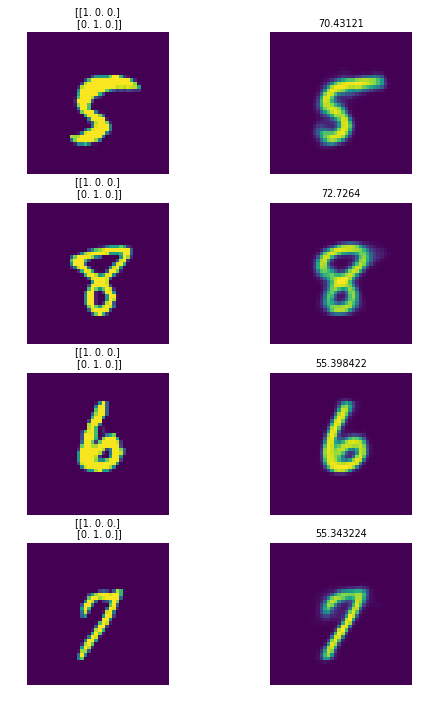

In [9]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="none", train=True)
valset = TransformedMNIST(data_path, transform_type="none", train=False)
train_loader = DataLoader(
    trainset, batch_size=8, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=8, num_workers=1, pin_memory=True, shuffle=False
)

model = AVAE2d(VAE=VAE2d(latent_size=8), opt_method="none").to(device)
save_path = "./results/mnist/test1/avae_none_noopt_l8"
checkpoint = torch.load(save_path + "/best_ckpt.pth")
model.load_state_dict(checkpoint["model"])

batch = next(iter(train_loader))
plot_recon(batch, model, nsamples=4)

no opt:
0.0 0.9967610239982605 0.06617176532745361
0.0 0.9986358284950256 0.0519372932612896
0.0 1.0 0.08268682658672333
0.0 0.9989534616470337 0.037301257252693176
rand_sgd_rot opt:
0.0 0.9967610239982605 0.06617176532745361
0.0 0.9986358284950256 0.0519372932612896
0.0 1.0 0.08268682658672333
0.0 0.9989534616470337 0.037301257252693176


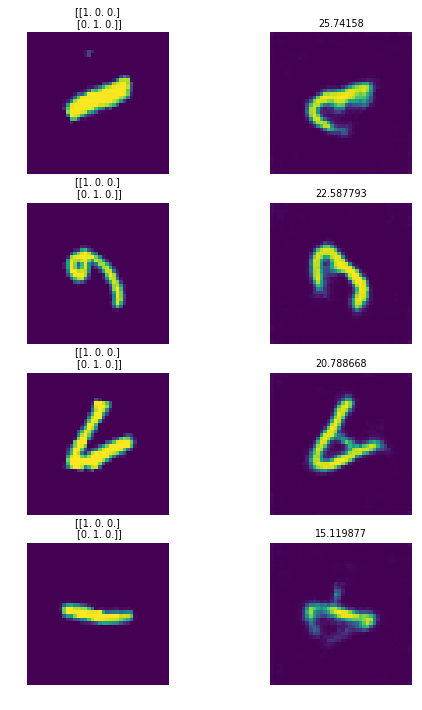

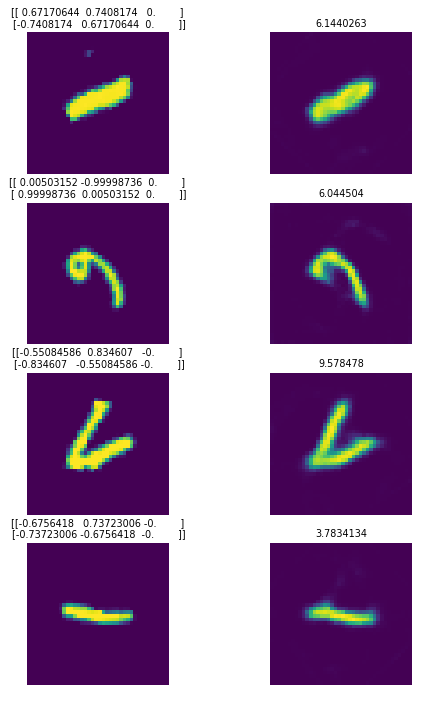

In [10]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="rand_rot", train=True)
valset = TransformedMNIST(data_path, transform_type="rand_rot", train=False)
train_loader = DataLoader(
    trainset, batch_size=8, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=8, num_workers=1, pin_memory=True, shuffle=False
)
batch = next(iter(train_loader))

save_path = './results/mnist/test3/randrot_l16_opt'
# save_path = "./results/mnist/test1/avae_none_noopt_l16"

print('no opt:')
model = AVAE2d(VAE=VAE2d(latent_size=16), opt_method="none").to(device)
checkpoint = torch.load(save_path + "/best_ckpt.pth")
model.load_state_dict(checkpoint["model"])
plot_recon(batch, model, nsamples=4)

print('rand_sgd_rot opt:')
model = AVAE2d(VAE=VAE2d(latent_size=16), opt_method="rand_sgd_rot").to(device)
model.load_state_dict(checkpoint["model"])
plot_recon(batch, model, nsamples=4)

0.0 0.9989205002784729 0.04915688559412956
0.0 1.0 0.0633573979139328
0.0 1.0 0.07054853439331055
0.0 0.9960784316062927 0.04072078689932823


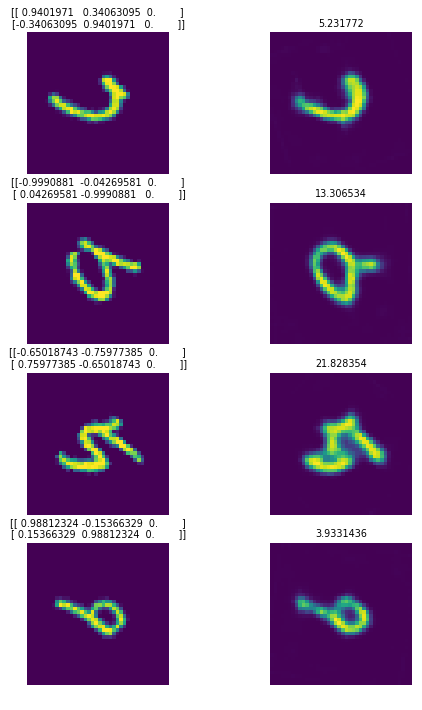

In [11]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="rand_rot", train=True)
valset = TransformedMNIST(data_path, transform_type="rand_rot", train=False)
train_loader = DataLoader(
    trainset, batch_size=8, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=8, num_workers=1, pin_memory=True, shuffle=False
)

model = AVAE2d(VAE=VAE2d(latent_size=16), opt_method="rand_sgd_rot").to(device)
save_path = './results/mnist/test3/randrot_l16_opt'

# save_path = "./results/mnist/test1/avae_none_noopt_l16"
checkpoint = torch.load(save_path + "/best_ckpt.pth")
model.load_state_dict(checkpoint["model"])

batch = next(iter(train_loader))
plot_recon(batch, model, nsamples=4)

## Is MSE lower on augmented or unaugmented data?

In [4]:
save_path_aug = "./results/mnist/test1/avae_aug_noopt_l"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l"
results = pd.DataFrame()

for i in range(10):
    checkpoint_noaug = torch.load(save_path_aug + "/" + str(i) + "_ckpt.pth")
    checkpoint_90aug = torch.load(save_path_noaug + "/" + str(i) + "_ckpt.pth")
    results = results.append(
        {w
            "epoch": checkpoint_noaug["epoch"],
            "noaug_mse": checkpoint_noaug["val_mse"],
            "90aug_mse": checkpoint_90aug["val_mse"],
        },
        ignore_index=True,
    )

fig = plt.figure(figsize=(8, 4))
plt.plot(results["epoch"], results["noaug_mse"], label="No Augmentation")
plt.plot(results["epoch"], results["90aug_mse"], label="With Augmentation")
plt.title("Validation MSE over training")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './results/mnist/test1/avae_aug_noopt_l/0_ckpt.pth'

dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
38.65136836547852
308936.8884277344
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
35.47424477539062
245568.62579345703
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
34.41525234375
226096.52575683594
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
34.102515228271486
215657.39810180664


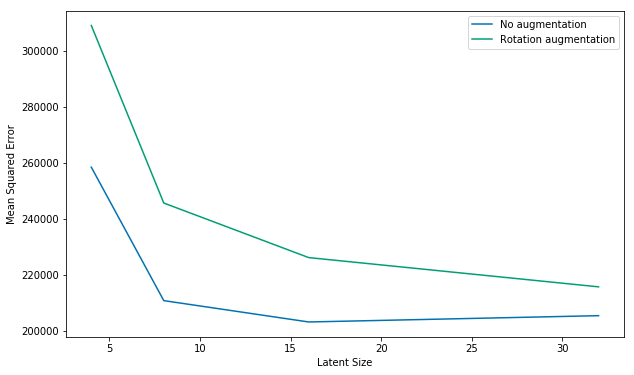

In [9]:
save_path_aug = "./results/mnist/test1/avae_aug_noopt_l"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l"
results = pd.DataFrame()

for i in [4, 8, 16, 32]:
    checkpoint_aug = torch.load(save_path_aug + str(i) + "/best_ckpt.pth")
    print(checkpoint_aug.keys())
    print(checkpoint_aug["val_loss"])
    print(checkpoint_aug["val_mse"])

    checkpoint_noaug = torch.load(save_path_noaug + str(i) + "/best_ckpt.pth")
    results = results.append(
        {
            "latent_size": i,
            "noaug_mse": checkpoint_noaug["val_mse"],
            "aug_mse": checkpoint_aug["val_mse"],
        },
        ignore_index=True,
    )

fig = plt.figure(figsize=(10, 6))
plt.plot(results["latent_size"], results["noaug_mse"], label="No augmentation")
plt.plot(results["latent_size"], results["aug_mse"], label="Rotation augmentation")
plt.xlabel("Latent Size", fontsize=10)
plt.ylabel("Mean Squared Error", fontsize=10)
plt.legend(prop={'size': 10})
plt.savefig("plots/mnist_mse_aug.pdf", format="eps")
plt.show()

## Rotation Optimization During Training

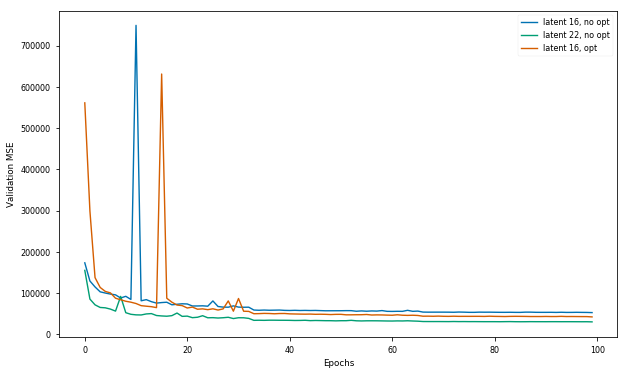

checkpoint_16 52813.16062927246
checkpoint_22 30330.629264831543
checkpoint_16opt 42388.76747131348


In [28]:
save_path_16 = './results/mnist/test3/randrot_l16_noopt'
save_path_22 = './results/mnist/test3/randrot_l22_noopt'
save_path_16opt = './results/mnist/test3/randrot_l16_opt'

checkpoint_16 = torch.load(save_path_16 + '/best_ckpt.pth')
checkpoint_22 = torch.load(save_path_22 + '/best_ckpt.pth')
checkpoint_16opt = torch.load(save_path_16opt + '/best_ckpt.pth')
    
fig = plt.figure(figsize=(10, 6))
plt.plot(list(range(len(checkpoint_16['results']['val_mse'][:100]))), checkpoint_16['results']['val_mse'][:100], label='latent 16, no opt')
plt.plot(list(range(len(checkpoint_22['results']['val_mse'][:100]))), checkpoint_22['results']['val_mse'][:100], label='latent 22, no opt')
plt.plot(list(range(len(checkpoint_16opt['results']['val_mse'][:100]))), checkpoint_16opt['results']['val_mse'][:100], label='latent 16, opt')
# plt.plot(list(range(len(checkpoint_16opt['results']['val_mse'][:100]))), checkpoint_16opt['results']['val_loss'][:100], label='latent 16, opt Loss')
# plt.plot(list(range(len(checkpoint_16opt['results']['train_loss'][:100]))), checkpoint_16opt['results']['train_loss'][:100], label='opt train loss')

# plt.title("Validation MSE over training")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.savefig('plots/randrot_mnist_l16_opt_training.eps', format='eps')
plt.show()

print(f"checkpoint_16 {checkpoint_16['val_mse']}")
print(f"checkpoint_22 {checkpoint_22['val_mse']}")
print(f"checkpoint_16opt {checkpoint_16opt['val_mse']}")

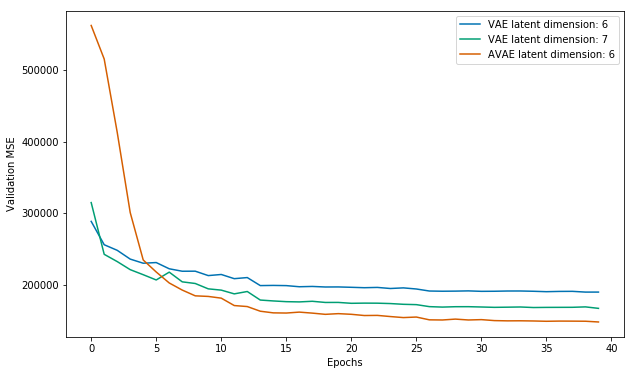

checkpoint 190416.08935546875
checkpoint_m 167752.38076782227
checkpoint_opt 148791.75131225586


In [18]:
save_path = './results/mnist/test3/randrot_l6_noopt'
save_path_m = './results/mnist/test3/randrot_l7_noopt'
save_path_opt = './results/mnist/test3/randrot_l6_opt'

checkpoint = torch.load(save_path + '/best_ckpt.pth')
checkpoint_m = torch.load(save_path_m + '/best_ckpt.pth')
checkpoint_opt = torch.load(save_path_opt + '/best_ckpt.pth')
    
fig = plt.figure(figsize=(10, 6))
plt.plot(list(range(len(checkpoint['results']['val_mse'][:100]))), checkpoint['results']['val_mse'][:100], label='VAE latent dimension: 6')
plt.plot(list(range(len(checkpoint_m['results']['val_mse'][:100]))), checkpoint_m['results']['val_mse'][:100], label='VAE latent dimension: 7')
plt.plot(list(range(len(checkpoint_opt['results']['val_mse'][:100]))), checkpoint_opt['results']['val_mse'][:100], label='AVAE latent dimension: 6')
# plt.plot(list(range(len(checkpoint_16opt['results']['val_mse'][:100]))), checkpoint_16opt['results']['val_loss'][:100], label='latent 16, opt Loss')
# plt.plot(list(range(len(checkpoint_16opt['results']['train_loss'][:100]))), checkpoint_16opt['results']['train_loss'][:100], label='opt train loss')


plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Validation MSE", fontsize=10)
plt.legend(prop={'size': 10})
plt.savefig('plots/randrot_mnist_l6_opt_training.pdf', format='pdf')
plt.show()

print(f"checkpoint {checkpoint['val_mse']}")
print(f"checkpoint_m {checkpoint_m['val_mse']}")
print(f"checkpoint_opt {checkpoint_opt['val_mse']}")
rot_perf = [checkpoint['val_mse'], checkpoint_m['val_mse'], checkpoint_opt['val_mse']]

## Rotation + Translation Optimization During Training

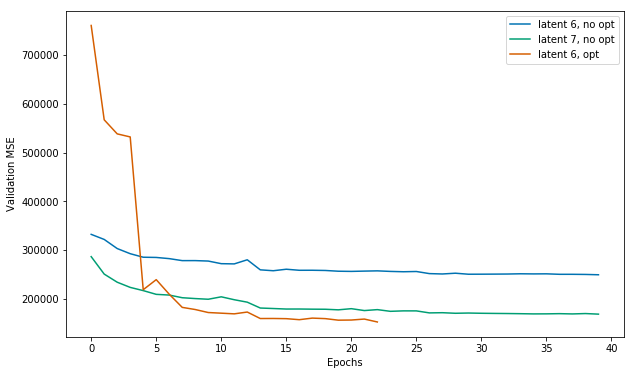

checkpoint 250174.99243164062
checkpoint_m 169657.4581298828
checkpoint_opt 153648.54556274414


In [5]:
save_path = './results/mnist/test3/randrottrans_l6_noopt'
save_path_m = './results/mnist/test3/randrottrans_l9_noopt'
save_path_opt = './results/mnist/test3/randrottrans_l6_opt'

checkpoint = torch.load(save_path + '/best_ckpt.pth')
checkpoint_m = torch.load(save_path_m + '/best_ckpt.pth')
checkpoint_opt = torch.load(save_path_opt + '/best_ckpt.pth')
    
fig = plt.figure(figsize=(10, 6))
plt.plot(list(range(len(checkpoint['results']['val_mse'][:100]))), checkpoint['results']['val_mse'][:100], label='latent 6, no opt')
plt.plot(list(range(len(checkpoint_m['results']['val_mse'][:100]))), checkpoint_m['results']['val_mse'][:100], label='latent 7, no opt')
plt.plot(list(range(len(checkpoint_opt['results']['val_mse'][:100]))), checkpoint_opt['results']['val_mse'][:100], label='latent 6, opt')

plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.savefig('plots/randrottrans_mnist_l6_opt_training.pdf', format='eps')
plt.show()

print(f"checkpoint {checkpoint['val_mse']}")
print(f"checkpoint_m {checkpoint_m['val_mse']}")
print(f"checkpoint_opt {checkpoint_opt['val_mse']}")
rot_trans_perf = [checkpoint['val_mse'], checkpoint_m['val_mse'], checkpoint_opt['val_mse']]

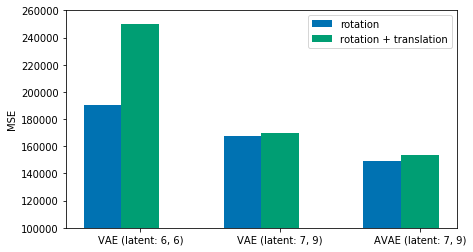

In [19]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
yvals = rot_perf
rects1 = ax.bar(ind, yvals, width)#)
zvals = rot_trans_perf
rects2 = ax.bar(ind+width, zvals, width)#, color='g')
# kvals = [11,12,13]
# rects3 = ax.bar(ind+width*2, kvals, width, color='b')


ax.set_ylabel('MSE')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('VAE (latent: 6, 6)', 'VAE (latent: 7, 9)', 'AVAE (latent: 7, 9)') )
ax.legend( (rects1[0], rects2[0]), ('rotation', 'rotation + translation') )
ax.set_ylim(100000, 260000)

plt.savefig('plots/mnist_avae_vae.pdf', format='pdf')
plt.show()


# import seaborn as sns
# x = list(range(3))
# df = pd.DataFrame(zip(x*3, ["y"]*3+["z"]*3, rot_perf+rot_trans_perf), columns=["time", "kind", "data"])
# plt.figure(figsize=(10, 6))
# sns.barplot(x="time", hue="kind", y="data", data=df)
# plt.show()

In [13]:
! pip install seaborn 

     |████████████████████████████████| 215 kB 7.2 MB/s eta 0:00:01


## Evolution over training

In [10]:
from tqdm import tqdm
save_path_aug = "./results/mnist/test3/randrot_l6_opt/"
data_aps = []
model_aps = []
diffs = np.zeros([20, 10000])

for epoch in tqdm(range(20)):
    checkpoint_aug = torch.load(save_path_aug + str(epoch) + "_ckpt.pth")
    data_aps.append(checkpoint_aug['data_ap_list'])
    model_aps.append(checkpoint_aug['model_ap_list'])
    diff = model_aps[epoch].squeeze() - data_aps[epoch].squeeze()
    for sample in range(10000):
        r = R.from_matrix(np.concatenate([diff[sample, :, :], 
                                      np.expand_dims(np.array([0, 0, 1]), axis=0)], axis=0))
        diffs[epoch, sample] = r.as_euler('zyx', degrees=True)[0]

# fig = plt.figure(figsize=(7, 4))
# plt.plot(results["latent_size"], results["noaug_mse"], label="No augmentation")
# plt.plot(results["latent_size"], results["aug_mse"], label="Rotation augmentation")
# plt.xlabel("Latent Size")
# plt.ylabel("MSE")
# plt.legend()
# plt.savefig("plots/mnist_mse_aug.eps", format="eps")
# plt.show()

100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


In [11]:
from utils_2d import make_affine2d, TransformedMNIST
val_augmentation = 'rand_rot'
valset = TransformedMNIST('./data/', transform_type=val_augmentation, train=False)
val_loader = DataLoader(valset, batch_size=1, num_workers=4, pin_memory=True, shuffle=False)

all_y = []
for batch in val_loader:
    all_y.append(batch['y'])
all_y = torch.cat(all_y)
all_y = all_y.detach().cpu().numpy()

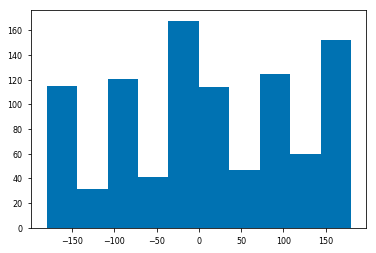

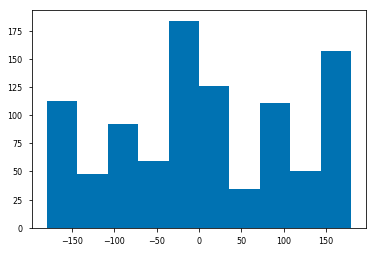

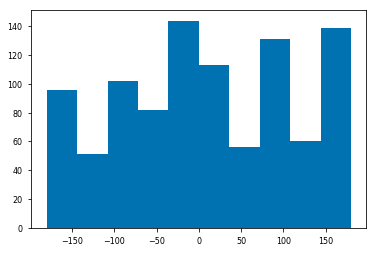

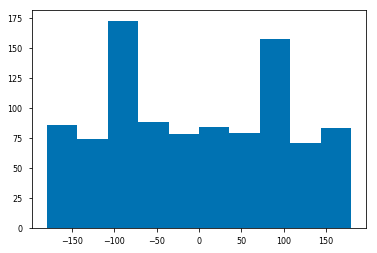

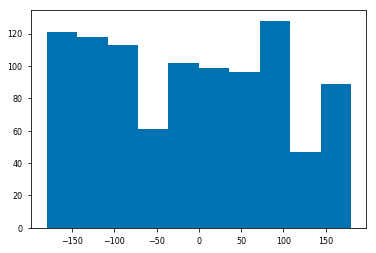

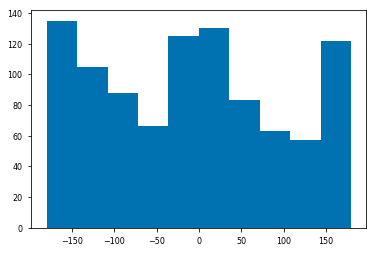

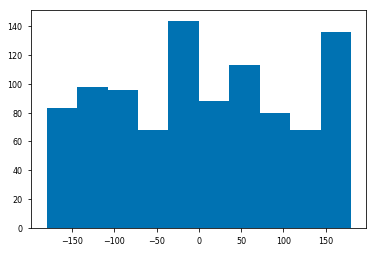

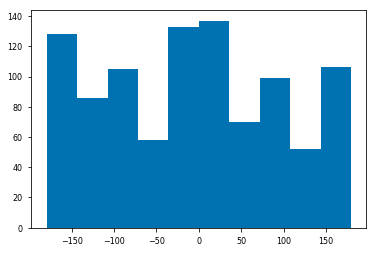

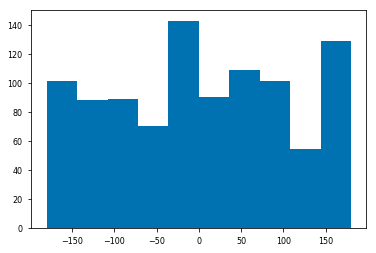

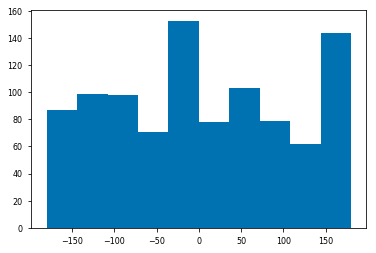

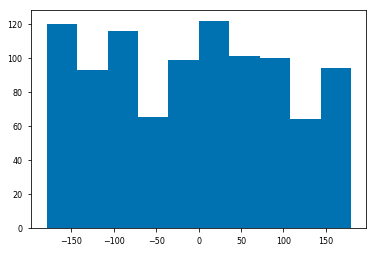

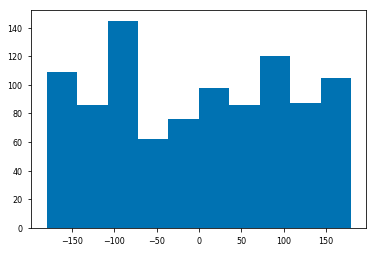

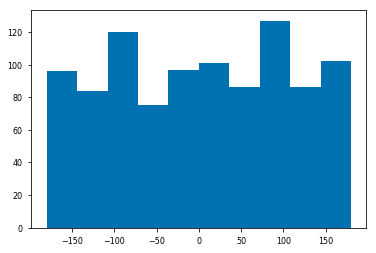

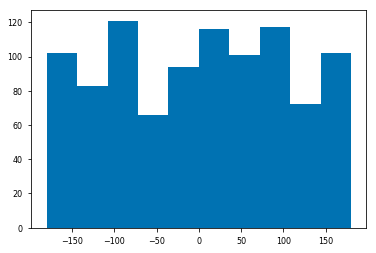

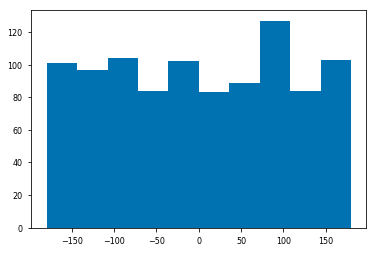

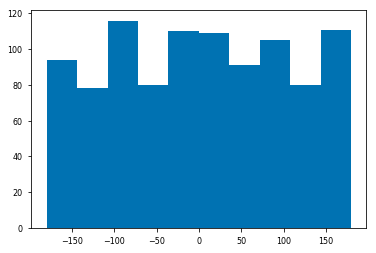

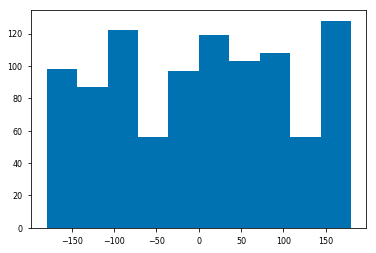

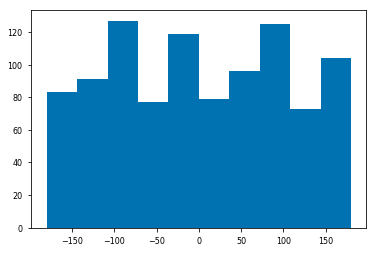

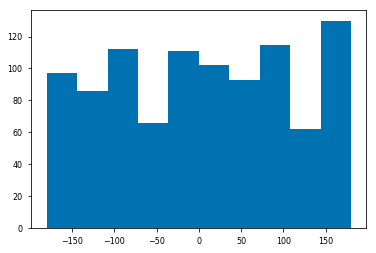

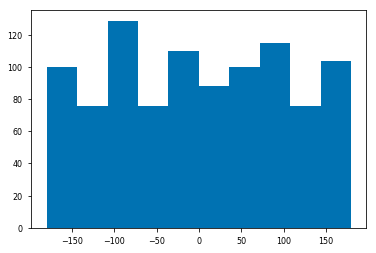

In [26]:
for epoch in range(20):
    plt.hist(diffs[epoch, all_y == 8])
    plt.show()


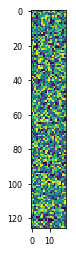

In [45]:
plt.imshow(diffs_1.T, interpolation='nearest')
plt.show()

In [8]:
for i in range(30):
    r = R.from_matrix(np.concatenate([diffs[0][i, :, :], 
                                  np.expand_dims(np.array([0, 0, 1]), axis=0)], axis=0))
    print(r.as_euler('zyx', degrees=True)[0])


96.32382529643634
179.55471086701846
15.439434562617027
1.7761331780224576
174.49856679175326
121.91458705933698
150.04133421480967
-102.38759951611537
143.95739900085817
179.5987771739117
163.1046631262264
143.5784825191083
162.69540584531654
-107.9653729974774
-58.777237667632164
149.89973320208475
-142.27196868000038
-145.2704365164879
-37.892125070026516
82.35187532883504
91.62715371749341
147.0615337883816
70.09788759208624
-169.26561917396936
153.93621326671862
-91.42270829300719
-21.716371711278715
65.74212303826208
172.75263718342043
-167.52500625354332


In [44]:
from scipy.spatial.transform import Rotation as R

f
r = R.from_matrix(np.concatenate([diffs[5, :, :], 
                                  np.expand_dims(np.array([0, 0, 1]), axis=0)], axis=0))
r.as_euler('zyx', degrees=False)

array([2.12781095, 0.        , 0.        ])

In [35]:
np.concatenate([diffs[0, :, :], 
                np.expand_dims(np.array([0, 0, 1]), axis=0)], axis=0)

array([[-0.95592511, -1.75113988,  0.        ],
       [ 1.75113988, -0.95592511,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [33]:
np.expand_dims(np.array([0, 0, 1]), axis=0).shape

(1, 3)

In [32]:
diffs[0, :, :].shape

(2, 3)

In [ ]:
data_ap = checkpoint_noopt['data_ap_list']
model_ap = checkpoint_noopt['model_ap_list']

data_dists = []
model_dists = []
data_model_dists = []
for i in range(rotation_array.shape[0]):
    data_dists.append(np.dot(rotationMatrixToEulerAngles(data_ap[i, :,:]), np.array([1, 1, 1])))
    model_dists.append(np.dot(rotationMatrixToEulerAngles(model_ap[i, :,:]), np.array([1, 1, 1])))
    data_model_dists.append(rotationMatrixToEulerAngles(np.matmul(np.squeeze(data_ap[i, :,:3]), np.squeeze(model_ap[i, :,:3]))))
    
Counter([''.join(str(e)) for e in data_model_dists])